<a href="https://colab.research.google.com/github/FikretZajmovic/senior-design-project/blob/week2/Sleep_Disorder_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

from google.colab import drive
drive.mount('/content/drive')

download_file_link = "https://drive.google.com/file/d/18VUJtZQzxc5xYUKMln6URL4z8CyXOW5S/view?usp=sharing"

df = pd.read_csv("/content/drive/MyDrive/SleepDisorderPrediction/Sleep_health_and_lifestyle_dataset.csv")

df.info()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Person ID                374 non-null    int64  
 1   Gender                   374 non-null    object 
 2   Age                      374 non-null    int64  
 3   Occupation               374 non-null    object 
 4   Sleep Duration           374 non-null    float64
 5   Quality of Sleep         374 non-null    int64  
 6   Physical Activity Level  374 non-null    int64  
 7   Stress Level             374 non-null    int64  
 8   BMI Category             374 non-null    object 
 9   Blood Pressure           374 non-null    object 
 10  Heart Rate               374 non-null    int64  
 11  Daily Steps              374 non-null    int64  
 12  Sleep

In [ ]:
df.head()

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


In [ ]:
df = df.dropna()

In [ ]:
label_encoders = {}

In [ ]:
label_encoders["Gender"] = LabelEncoder()
df["Gender"] = label_encoders["Gender"].fit_transform(df["Gender"])  # Male=1, Female=0

In [ ]:
label_encoders["BMI Category"] = LabelEncoder()
df["BMI Category"] = label_encoders["BMI Category"].fit_transform(df["BMI Category"])

In [ ]:
label_encoders["Sleep Disorder"] = LabelEncoder()
df["Sleep Disorder"] = label_encoders["Sleep Disorder"].fit_transform(df["Sleep Disorder"])  # Sleep Disorder: None=0, Insomnia=1, Sleep Apnea=2

In [ ]:
df[["Systolic_BP", "Diastolic_BP"]] = df["Blood Pressure"].str.split("/", expand=True)

df["Systolic_BP"] = pd.to_numeric(df["Systolic_BP"])
df["Diastolic_BP"] = pd.to_numeric(df["Diastolic_BP"])

df = df.drop(columns=["Blood Pressure"])

In [ ]:
features = ["Age", "Gender", "Sleep Duration", "Quality of Sleep", "Physical Activity Level", "Stress Level", "BMI Category",
            "Systolic_BP", "Diastolic_BP", "Heart Rate", "Daily Steps"]
columns_order = ["Person ID", "Age", "Gender", "Occupation", "Sleep Duration", "Quality of Sleep", "Physical Activity Level", "Stress Level", "BMI Category",
            "Systolic_BP", "Diastolic_BP", "Heart Rate", "Daily Steps", "Sleep Disorder"]
df = df[columns_order]

In [ ]:
X = df[features]
y = df["Sleep Disorder"]

In [ ]:
scaler = StandardScaler()
X[["Age", "Sleep Duration", "Quality of Sleep", "Physical Activity Level",
   "Stress Level", "Systolic_BP", "Diastolic_BP", "Heart Rate", "Daily Steps"]] = scaler.fit_transform(
    X[["Age", "Sleep Duration", "Quality of Sleep", "Physical Activity Level",
       "Stress Level", "Systolic_BP", "Diastolic_BP", "Heart Rate", "Daily Steps"]])

<ipython-input-12-8e130f7d6be2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[["Age", "Sleep Duration", "Quality of Sleep", "Physical Activity Level",


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Training set: {X_train.shape}, Testing set: {X_test.shape}")

Training set: (124, 11), Testing set: (31, 11)


Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [ ]:
y_pred = logreg.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.81


In [ ]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.81      0.81      0.81        16

    accuracy                           0.81        31
   macro avg       0.81      0.81      0.81        31
weighted avg       0.81      0.81      0.81        31



In [ ]:
feature_importance = abs(logreg.coef_[0])
feature_names = X.columns

sorted_idx = np.argsort(feature_importance)[::-1]

print("\nFeature Importance Ranking:")
for i in sorted_idx:
    print(f"{feature_names[i]}: {feature_importance[i]:.4f}")


Feature Importance Ranking:
Sleep Duration: 1.6064
Diastolic_BP: 1.4849
Heart Rate: 1.4257
Daily Steps: 1.3725
Gender: 1.1916
Age: 0.6828
Systolic_BP: 0.2930
Stress Level: 0.2248
Physical Activity Level: 0.1419
Quality of Sleep: 0.0973
BMI Category: 0.0019


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

grid_search = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5)
grid_search.fit(X_train, y_train)

print(f"Best C value: {grid_search.best_params_['C']}")

best_logreg = LogisticRegression(C=grid_search.best_params_['C'], max_iter=1000)
best_logreg.fit(X_train, y_train)

y_pred_best = best_logreg.predict(X_test)
print("\nUpdated Classification Report:")
print(classification_report(y_test, y_pred_best))

Best C value: 0.01

Updated Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        15
           1       0.91      0.62      0.74        16

    accuracy                           0.77        31
   macro avg       0.80      0.78      0.77        31
weighted avg       0.81      0.77      0.77        31



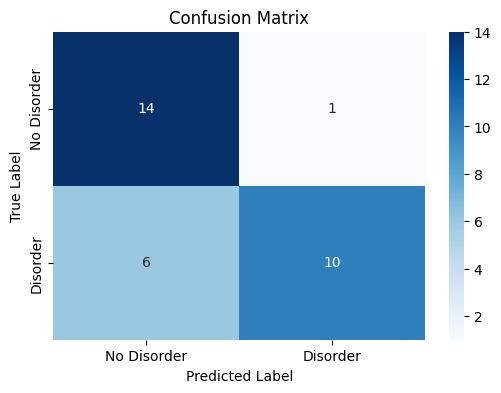

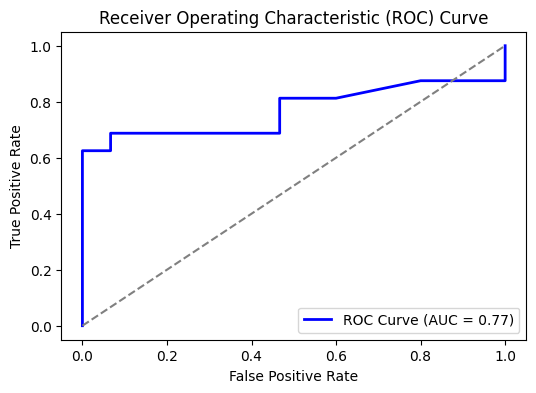

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

y_prob = best_logreg.predict_proba(X_test)[:, 1]
y_pred_adjusted = (y_prob >= 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred_adjusted)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["No Disorder", "Disorder"], yticklabels=["No Disorder", "Disorder"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

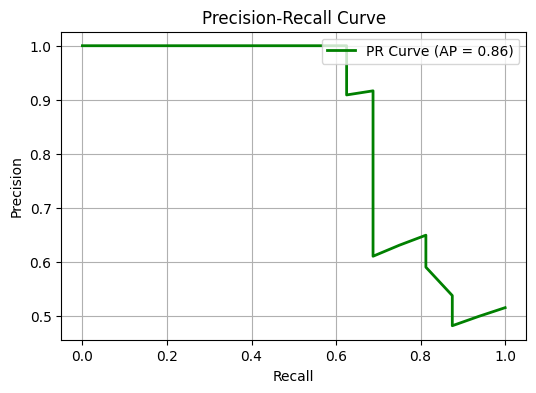

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
avg_precision = average_precision_score(y_test, y_prob)

plt.figure(figsize=(6, 4))
plt.plot(recall, precision, color='green', lw=2, label=f'PR Curve (AP = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

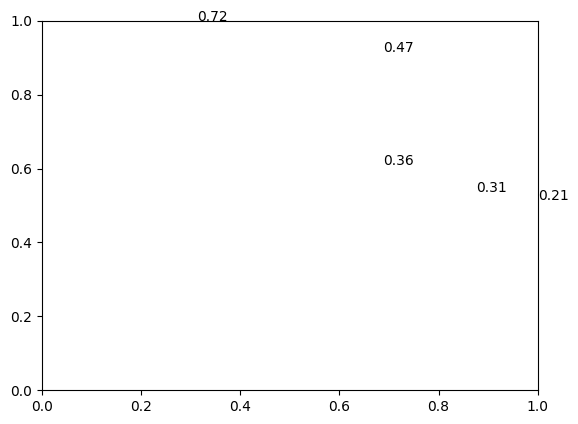

In [ ]:
for i, t in enumerate(thresholds[::5]):
    plt.annotate(f"{t:.2f}", (recall[::5][i], precision[::5][i]))

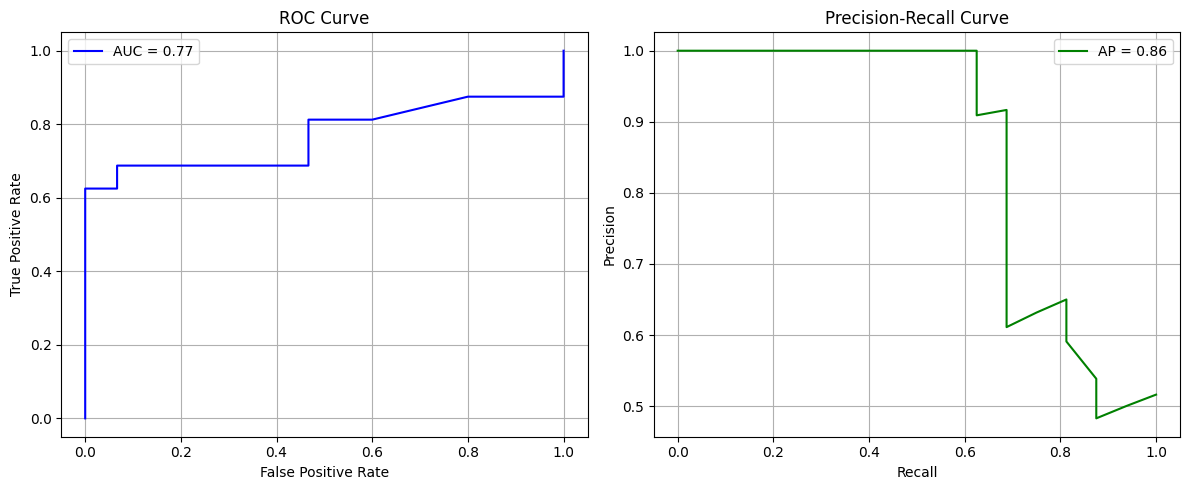

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
# ROC
axs[0].plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", color='blue')
axs[0].set_title("ROC Curve")
axs[0].set_xlabel("False Positive Rate")
axs[0].set_ylabel("True Positive Rate")
axs[0].legend()
axs[0].grid(True)
# PR
axs[1].plot(recall, precision, label=f"AP = {avg_precision:.2f}", color='green')
axs[1].set_title("Precision-Recall Curve")
axs[1].set_xlabel("Recall")
axs[1].set_ylabel("Precision")
axs[1].legend()
axs[1].grid(True)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[12  3]
 [ 3 13]]
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.81      0.81      0.81        16

    accuracy                           0.81        31
   macro avg       0.81      0.81      0.81        31
weighted avg       0.81      0.81      0.81        31



In [ ]:
importance = logreg.coef_[0]
for i, col in enumerate(X.columns):
    print(f"{col}: {importance[i]:.4f}")

Age: -0.6828
Gender: -1.1916
Sleep Duration: 1.6064
Quality of Sleep: 0.0973
Physical Activity Level: -0.1419
Stress Level: 0.2248
BMI Category: -0.0019
Systolic_BP: -0.2930
Diastolic_BP: 1.4849
Heart Rate: 1.4257
Daily Steps: 1.3725


In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(logreg, X, y, cv=5, scoring='average_precision')
print("Cross-validated average precision:", scores.mean())

Cross-validated average precision: 0.8790856457038991


Artifical Neural Networks

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.3117 - loss: 1.7559 - val_accuracy: 0.7742 - val_loss: 0.8813
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5795 - loss: 0.9443 - val_accuracy: 0.8065 - val_loss: 0.8212
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6502 - loss: 0.9372 - val_accuracy: 0.7742 - val_loss: 0.7707
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7030 - loss: 0.8135 - val_accuracy: 0.7742 - val_loss: 0.7313
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7527 - loss: 0.7219 - val_accuracy: 0.7742 - val_loss: 0.7011
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7686 - loss: 0.6514 - val_accuracy: 0.7742 - val_loss: 0.6790
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8017 - loss: 0.5800 - val_accuracy: 0.7742 - val_loss: 0.6605
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8065 - loss: 0.5188 - val_accuracy: 0.8065 - val_loss: 0.6396
Epoch 9/50


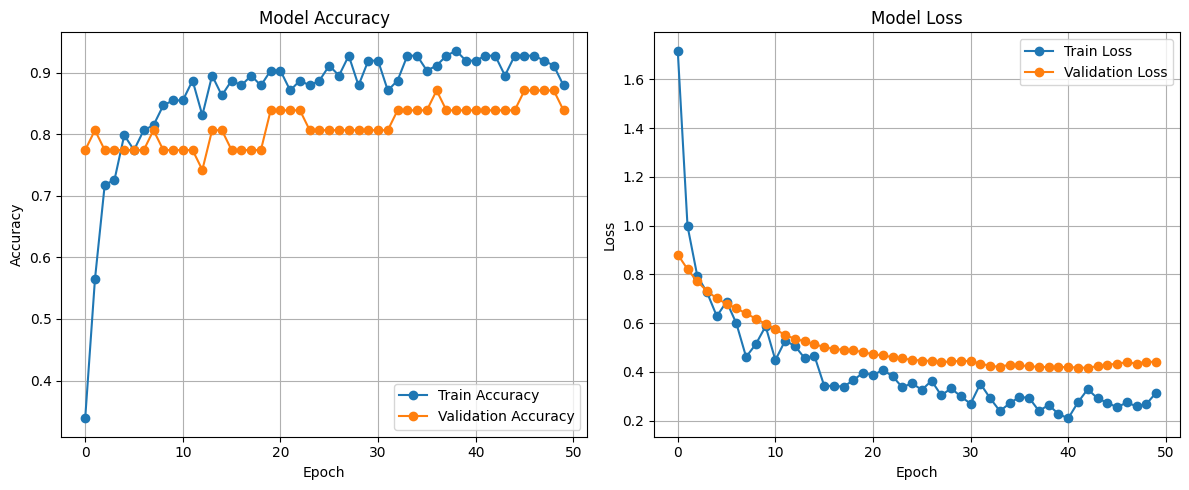

In [10]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, f1_score
import matplotlib.pyplot as plt

df = pd.read_csv("/content/drive/MyDrive/SleepDisorderPrediction/Sleep_health_and_lifestyle_dataset.csv")

df = df.dropna()

label_encoders = {}

label_encoders["Gender"] = LabelEncoder()
df["Gender"] = label_encoders["Gender"].fit_transform(df["Gender"])  # Male=1, Female=0

label_encoders["BMI Category"] = LabelEncoder()
df["BMI Category"] = label_encoders["BMI Category"].fit_transform(df["BMI Category"])

label_encoders["Sleep Disorder"] = LabelEncoder()
df["Sleep Disorder"] = label_encoders["Sleep Disorder"].fit_transform(df["Sleep Disorder"])  # None=0, Insomnia=1, Sleep Apnea=2

df[["Systolic_BP", "Diastolic_BP"]] = df["Blood Pressure"].str.split("/", expand=True).astype(float)
df = df.drop(columns=["Blood Pressure"])

features = ["Age", "Gender", "Sleep Duration", "Quality of Sleep", "Physical Activity Level", "Stress Level",
            "BMI Category", "Systolic_BP", "Diastolic_BP", "Heart Rate", "Daily Steps"]

X = df[features].copy()
y = df["Sleep Disorder"]

scaler = StandardScaler()
X[features] = scaler.fit_transform(X[features])

y_onehot = tf.keras.utils.to_categorical(y, num_classes=3)

X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42, stratify=y)

ann_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

ann_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

history = ann_model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=1)

y_pred_prob = ann_model.predict(X_test)
y_pred_labels = np.argmax(y_pred_prob, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

print("\nANN Classification Report:")
print(classification_report(y_test_labels, y_pred_labels, target_names=label_encoders["Sleep Disorder"].classes_))

accuracy = accuracy_score(y_test_labels, y_pred_labels)
precision = precision_score(y_test_labels, y_pred_labels, average='macro')
f1 = f1_score(y_test_labels, y_pred_labels, average='macro')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"F1-score: {f1:.2f}")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Support Vector Machine

<ipython-input-12-b386310fed9f>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[features] = scaler.fit_transform(X[features])



SVM Classification Report:
              precision    recall  f1-score   support

    Insomnia       0.88      0.93      0.90        15
 Sleep Apnea       0.93      0.88      0.90        16

    accuracy                           0.90        31
   macro avg       0.90      0.90      0.90        31
weighted avg       0.91      0.90      0.90        31

Accuracy: 0.90
Precision: 0.90
F1-score: 0.90


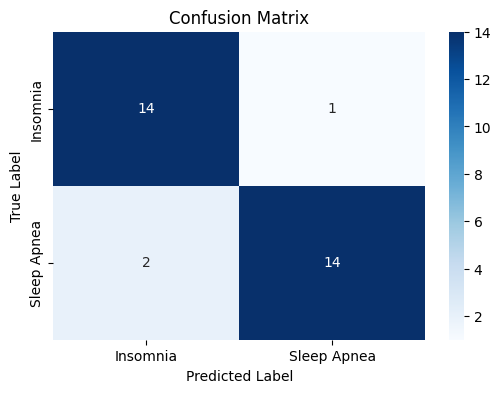

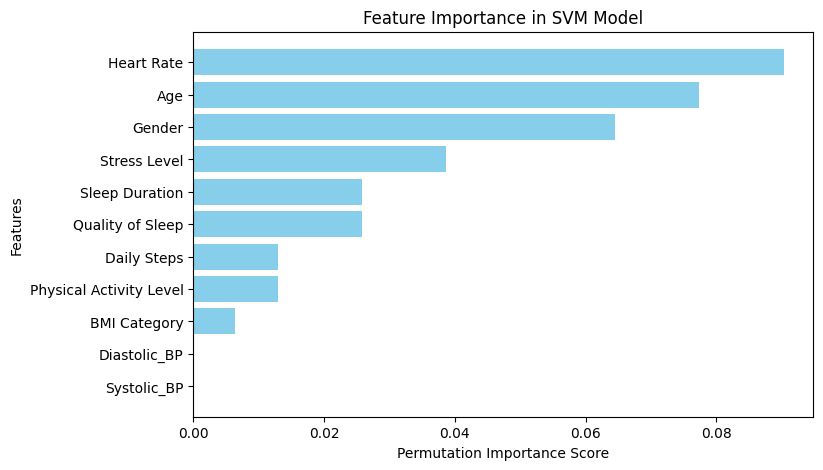

<ipython-input-12-b386310fed9f>:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_pred, palette="Set2")


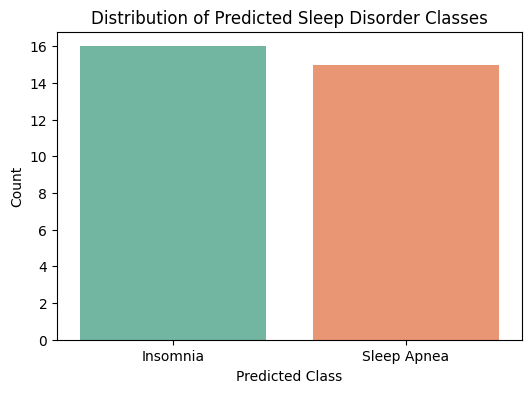

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, precision_score, f1_score, confusion_matrix
from sklearn.inspection import permutation_importance

df = pd.read_csv("/content/drive/MyDrive/SleepDisorderPrediction/Sleep_health_and_lifestyle_dataset.csv")

df = df.dropna()

label_encoders = {}

label_encoders["Gender"] = LabelEncoder()
df["Gender"] = label_encoders["Gender"].fit_transform(df["Gender"])  # Male=1, Female=0

label_encoders["BMI Category"] = LabelEncoder()
df["BMI Category"] = label_encoders["BMI Category"].fit_transform(df["BMI Category"])

label_encoders["Sleep Disorder"] = LabelEncoder()
df["Sleep Disorder"] = label_encoders["Sleep Disorder"].fit_transform(df["Sleep Disorder"])  # None=0, Insomnia=1, Sleep Apnea=2

df[["Systolic_BP", "Diastolic_BP"]] = df["Blood Pressure"].str.split("/", expand=True).astype(float)
df = df.drop(columns=["Blood Pressure"])

features = ["Age", "Gender", "Sleep Duration", "Quality of Sleep", "Physical Activity Level", "Stress Level",
            "BMI Category", "Systolic_BP", "Diastolic_BP", "Heart Rate", "Daily Steps"]

X = df[features]
y = df["Sleep Disorder"]

scaler = StandardScaler()
X[features] = scaler.fit_transform(X[features])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

svm_model = SVC(kernel='rbf', C=1, gamma='scale')
svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)

print("\nSVM Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoders["Sleep Disorder"].classes_))

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"F1-score: {f1:.2f}")

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoders["Sleep Disorder"].classes_,
            yticklabels=label_encoders["Sleep Disorder"].classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

perm_importance = permutation_importance(svm_model, X_test, y_test, scoring='accuracy', random_state=42)
feature_importance = perm_importance.importances_mean
sorted_idx = np.argsort(feature_importance)[::-1]

plt.figure(figsize=(8, 5))
plt.barh(np.array(features)[sorted_idx], feature_importance[sorted_idx], color='skyblue')
plt.xlabel("Permutation Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance in SVM Model")
plt.gca().invert_yaxis()
plt.show()

plt.figure(figsize=(6, 4))
sns.countplot(x=y_pred, palette="Set2")
unique_classes = np.sort(np.unique(y_pred))
plt.xticks(ticks=unique_classes, labels=[label_encoders["Sleep Disorder"].classes_[i] for i in unique_classes])
plt.xlabel("Predicted Class")
plt.ylabel("Count")
plt.title("Distribution of Predicted Sleep Disorder Classes")
plt.show()